# Building a Representative Corpus of Jazz Piano Trio Recordings

Procedure:
1. Authenticate with both LastFM and Musicbrainz APIs;
2. Scrape LastFM to get a list of the most popular jazz artists with 'trio' in their name;
3. Cross-reference the artists scraped from LastFM with two reference jazz discographies, removing those who don't feature in either;
4. Scrape Musicbrainz using the artist names and gather information on each of their releases;
5. Using the release information, group find the number of tracks recorded by all combinations of musicians that recorded under each act name;
6. Find the top 30 combinations of musicians who recorded the greatest number of tracks.

## Import dependencies, set constants etc.

In [1]:
import pandas as pd
import numpy as np
import dotenv
import requests
import hashlib
import os
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import musicbrainzngs
import warnings
from ast import literal_eval
from builtins import any as b_any
from datetime import timedelta, datetime
from dateutil.parser import parse, ParserError
from tqdm.notebook import tqdm
from requests.exceptions import ConnectionError
import csv
from collections import defaultdict

import src.utils.analyse_utils as autils

In [2]:
# These options just make the outputs from each cell look cleaner
pd.set_option('display.max_rows', 20)
pd.options.mode.chained_assignment = None
logging.getLogger().setLevel(logging.ERROR)
plt.rcParams.update({'font.size': 18})
plt.style.use('default')

In [3]:
# These variables are constants and can be changed if needed
N_PAGES = 500  # The number of LastFM pages to scrape artist information from
N_ARTISTS = 500  # The number of artists per LastFM page
LASTFM_ENDPOINT = "https://ws.audioscrobbler.com/2.0"  # This is the LastFM API root directory that we will make our calls to
GENRE = 'jazz'  # The LastFM genre to scrape for artist names
SEARCH_TAG = 'trio'  # Only consider artists that have this tag in their name
USABLE_TRACKS_WORST_CASE = 1/4    # In the worst case, we assume that only this percentage of total tracks will be usable in the corpus

In [4]:
# Define the reader function to load in the required text file
reader = lambda f: open(fr'{autils.get_project_root()}\references\corpus_construction\{f}.txt', "r").read().splitlines()

## Authenticate APIs

To access the LastFM API, we need an API key, which must be applied for manually. The procedure for doing so is out of scope for this notebook. Follow the advice given in the [LastFM API documentation](https://www.last.fm/api/authentication): you will first need to register for a user account before you can apply for an API key.

Once you have an API key, this should be stored as an environment variables within a file called `.env` that is saved in the root directory of this project folder. Define the LastFM key as `LASTFM_API_KEY`. This will then be loaded in automatically using the `dotenv` package within the following few lines.

Musicbrainz does not currently require authentication, beyond setting a user agent. You should store a contact email in `.env`, under the `CONTACT_EMAIL` variable.

In [5]:
# Load in the environment variables we require for authentication
dotenv.load_dotenv(rf"{autils.get_project_root()}\.env")

True

In [6]:
# Load in our LastFM API key from .env
LASTFM_API_KEY = os.getenv('LASTFM_API_KEY')

In [7]:
# This is all the authentication required for Musicbrainz
CONTACT_EMAIL = os.getenv('CONTACT_EMAIL')
LISTENBRAINZ_URL = 'https://listenbrainz.org/player/?recording_mbids='
musicbrainzngs.set_useragent('Jazz-Corpus-Analysis', 1, CONTACT_EMAIL)

In [8]:
# These authentication variables aren't currently used, but are created now in case we do end up using them later
LASTFM_SHARED_SECRET = os.getenv('LASTFM_SHARED_SECRET')
LASTFM_TOKEN = eval(
    requests.get(f"{LASTFM_ENDPOINT}/?method=auth.gettoken&api_key={LASTFM_API_KEY}&format=json").text
)['token']
LASTFM_API_SIGNATURE = hashlib.md5(
    f"api_key{LASTFM_API_KEY}methodauth.getSessiontoken{LASTFM_TOKEN}{LASTFM_SHARED_SECRET}".encode('utf-8')
)

## Scrape artist data from LastFM using API

The following cells scrape data from the LastFM API using the information and keys created in the cells above.

In [ ]:
def get_total_streams(mbid: str) -> dict:
    """Gets the total number of streams for an artist by their ID, across all tracks and albums"""
    # Make the API request
    request = requests.get(
        f"{LASTFM_ENDPOINT}/?method=artist.getinfo&mbid={mbid}&api_key={LASTFM_API_KEY}&format=json"
    ).json()
    # Get the required variable from the request JSON object
    return {'playcount': request['artist']['stats']['playcount']}


def get_top_n_track_streams(mbid: str, num_tracks: int = 3) -> dict:
    """Gets the number of streams for the top n tracks by an artist, by their ID"""
    # Make the API request
    request = requests.get(
        f"{LASTFM_ENDPOINT}/?method=artist.gettoptracks&mbid={mbid}&api_key={LASTFM_API_KEY}&format=json"
    ).json()
    res_ = {}
    # Iterate through the required number of tracks
    for tr in range(num_tracks):
        # Get the name and play count from the given track
        res_[f'track_{tr + 1}_name'] = request['toptracks']['track'][tr]['name']
        res_[f'track_{tr + 1}_plays'] = request['toptracks']['track'][tr]['playcount']
    return res_

In [ ]:
def process_artist(artist_: dict) -> dict:
    """Central function for processing data from a single artist scraped from LastFM"""
    if SEARCH_TAG.upper() in str(artist_['name']).upper():
        # We make everything upper case to address any case-sensitivity issues
        return {
            **artist_,
            **get_total_streams(mbid=artist_['mbid']),
            **get_top_n_track_streams(mbid=artist_['mbid']),
        }

In [ ]:
# Empty list to hold our processed data
trios = []

In [ ]:
# Iterate through each page of artists on LastFM
for i in tqdm(range(1, N_PAGES)):
    # Make the API request
    try:
        tag = requests.get(
            f"{LASTFM_ENDPOINT}/?method=tag.gettopartists&tag={GENRE}&api_key={LASTFM_API_KEY}&page={i}&perpage={N_ARTISTS}&format=json"
        )
    # If we time out, log and then continue to the next page
    except ConnectionError as e:
        print(e)
        pass
    # If we receive data, iterate through each artist in turn and process it
    else:
        for k, v in tag.json().items():
            for k_, v_ in v.items():
                for lastfm_artist in v_:
                    # Try and process the data for one artist
                    try:
                        trios.append(process_artist(lastfm_artist))
                    # Catch errors resulting from irregular item construction, timeouts, and continue
                    except (TypeError, KeyError, ConnectionError) as e:
                        pass

In [ ]:
# Concatenate the artist information and drop any duplicates (by ID)
df = (
    pd.DataFrame([t for t in trios if t is not None])
    .drop_duplicates(subset=['mbid'])
    .drop(columns=['image', 'streamable', '@attr'])
)

## Subset data to only include artists in reference discographies

In order to ensure that the artists we include in the corpus played a non-trivial role in jazz history, we cross-reference the list of artists scraped from LastFM with two reference discographies, defined as:

- Gioia, T. (2011). The History of Jazz (2nd ed.). New York: Oxford University Press. (`gioia`)
- Levine, M. (2011). The Jazz Theory Book. Sebastopol: Sher Music Company. (`levine`)

If an artist can be found in the dataset scraped from LastFM AND one of the following discographies AND it passes a final manual check against the inclusion criteria, then they can be included in the corpus.

In [ ]:
# Load in the reference discographies and list of appropriate artists
levine = reader('levine')
gioia = reader('gioia')
appropriate = reader('appropriate')

In [ ]:
# Subset the dataframe to include artists in one of the two discographies & that are acceptable to the inclusion criteria
df_cut = df[(df['name'].isin(levine)) | (df['name'].isin(gioia))]
df_cut = df[(df['name'].isin(appropriate))].reset_index(drop=True)

In [ ]:
df_cut.to_csv(fr'{autils.get_project_root()}\references\corpus_construction\lastfm_piano_trio_search.csv')

In [ ]:
try:
    df_cut
except NameError:
    df_cut = pd.read_csv(fr'{autils.get_project_root()}\references\corpus_construction\lastfm_piano_trio_search.csv')

## Scrape release metadata from Musicbrainz

Once we have our list of artists from LastFM, we can now turn to scraping [Musicbrainz](https://musicbrainz.org/) to gather information on their individual releases. This will enable us to understand how many trio releases individual bandleaders made, and how many tracks were on each of these releases. This will also allow us to scrape information about the individual performers on each record, which can then be used to estimate the different networks of musicians that formed part of a named 'trio' over time.

In [ ]:
def get_mbz_artist_id(artist_str):
    """Searches Musicbrainz using an artist's name and returns the ID with the closest match"""
    return musicbrainzngs.search_artists(artist=artist_str)['artist-list'][0]['id']

def get_mbz_artist_release_groups(
        artist_id_,
        release_types: tuple = ('album', 'live'),
        limit: int = 100,
):
    """Returns all release groups associated with a particular artist, by their musicbrainz ID.

    A release group is, essentially, a 'master' recording that may have been printed and pressed under
    multiple different titles, in different formats, and in different countries over the years.
    """
    for release_type in release_types:
        # This gets the item offset
        offset = int(np.floor(musicbrainzngs.browse_release_groups(
            artist=artist_id_,
            release_type=release_type,
            limit=1,
        )['release-group-count'] / 100))
        for off in range(offset + 1):
            yield from musicbrainzngs.browse_release_groups(
                artist=artist_id_,
                release_type=release_type,
                limit=limit,
                includes=['artist-credits'],
                offset=off
            )['release-group-list']


def get_earliest_mbz_release_from_release_group(
        release_grp_: dict,
        release_status: tuple = 'official',
        limit: int = 100,
) -> dict | None:
    """Get the information relating to the first release of a record from a release group"""

    # Browse musicbrainz to get all releases under this release group
    releases_ = musicbrainzngs.browse_releases(
        release_group=release_grp_['id'],
        release_status=release_status,
        limit=limit,    # We don't use offsets here, we won't have more than 100 unique releases of one record
    )['release-list']
    # Empty lists to store our release data and ID variables
    dates = []
    ids = []
    # Iterate through all the releases of this record
    for rel in releases_:
        # Try and parse the date to a machine-readable format, and keep the ID too
        try:
            dates.append(parse(rel['date'], fuzzy=True))
        # If we don't have a date for this release, continue to the next one
        except KeyError:
            continue
        # Keep the IDs of any releases where we also have dates
        else:
            ids.append(rel['id'])
    # Return the release whose ID matches the ID of the chronologically-earliest release
    try:
        return [rel for rel in releases_ if rel['id'] == ids[np.argmin(dates)]][0]
    # If none of the releases have dates associated with them, try and return the first release in the list
    except (ValueError, IndexError):
        try:
            return releases_[0]
        # If we have an error here, it's because we don't have any releases in the first place, so return None
        except IndexError:
            return None


def getter(collection: str, attribute: str, nest: str = None, fallback=''):
    """Simple wrapper function for attempting to get an item from a dictionary"""
    try:
        # If we've passed a nest level in, subset our collection by this level
        if nest is not None:
            collection = collection[nest]
        return collection[attribute]
    # If we don't have our attribute in the dictionary, return our fallback (empty string)
    except KeyError:
        return fallback


def get_work_info(track):
    try:
        work_list = track['recording']['work-relation-list']
    except KeyError:
        return {}
    else:
        for work in work_list:
            yield {
                'work_begin': getter(work, 'begin'),
                'work_end': getter(work, 'end'),
                'work_title': getter(work, 'title', nest='work'),
                'work_type': getter(work, 'type'),
            }


def get_release_info(rel):
    return {
        'release_title': getter(rel, 'title', nest='release'),
        'release_status': getter(rel, 'status', nest='release'),
        'release_quality': getter(rel, 'quality', nest='release'),
        'release_id': getter(rel, 'id', nest='release'),
        'release_packaging': getter(rel, 'packaging', nest='release'),
        'release_date': getter(rel, 'date', nest='release'),
        'release_country': getter(rel, 'country', nest='release'),
    }

def get_artist_info(track):
    try:
        artist_list = track['recording']['artist-relation-list']
    except KeyError:
        return {}
    else:
        for artist_ in artist_list:
            yield {
                'artist_id': getter(artist_, 'id', nest='artist'),
                'artist_role': getter(artist_, 'attribute-list'),
                'artist_name': getter(artist_, 'name', nest='artist'),
                'artist_type': getter(artist_, 'type'),
                'artist_begin': getter(artist_, 'begin'),
                'artist_end': getter(artist_, 'end'),
                'artist_details': getter(artist_, 'disambiguation', nest='artist'),
            }

def get_release_artist(track):
    try:
        return [getter(a['artist'], 'name') for a in track['recording']['artist-credit'] if isinstance(a, dict)]
    except (KeyError, TypeError):
        return ''


def get_recording_info(track):
    return {
        'recording_position': getter(track, 'position'),
        'recording_number': getter(track, 'number'),
        'recording_length': getter(track, 'length'),
        'recording_id_for_lbz': getter(track, 'id', nest='recording'),
        'recording_title': getter(track, 'title', nest='recording'),
        'track_id_maybe_not_needed': getter(track, 'id')
    }


def parse_mbz_release_info(release: dict, searched_artist_name: str) -> dict:
    """Parses artist and contributor info from a musicbrainz release"""
    # Get the release by our ID and include the values we need
    rel = musicbrainzngs.get_release_by_id(
        id=release['id'],
        includes=[
            'artist-credits',
            'labels',
            'recordings',
            'recording-level-rels',
            'work-rels',
            'work-level-rels',
            'artist-rels'
        ],
        release_status=['official']
    )
    release_info = get_release_info(rel)
    # Medium list: the list of 'things' in a release, e.g. individual CDs, discs
    try:
        medium_list = rel['release']['medium-list']
    except KeyError:
        return
    else:
        for medium in medium_list:
            # Track list: the list of pieces/songs/tracks on a medium
            try:
                track_list = medium['track-list']
            except KeyError:
                continue
            else:
                for track in track_list:
                    yield {
                        'searched_artist_name': searched_artist_name,
                        'release_artist': get_release_artist(track),
                        **release_info,
                        **get_recording_info(track),
                        'artist_list': list(get_artist_info(track)),
                        'work_list': list(get_work_info(track)),
                    }


def get_artist_title_for_writing(name):
    """Replaces invalid characters in an artist name string so that it can be saved"""
    return name.replace(" ", "_").replace("\\", "_").replace('/', '_').lower()

def write_artist_release_info_to_csv(artist_releases: list, artist_name: str):
    """Dumps release information from a particular artist to a .csv file"""
    pd.DataFrame(artist_releases).to_csv(fr'{autils.get_project_root()}\references\corpus_construction\musicbrainz_search\{artist_name}.csv')


# Obtain the list of artists that we've already processed
preprocessed = os.listdir(fr'{autils.get_project_root()}\references\corpus_construction\musicbrainz_search')
# Read in the list of valid artist names from our text file
musicbrainz_artists = pd.read_csv(fr'{autils.get_project_root()}\references\corpus_construction\musicbrainz_artists.csv')['artist'].to_list()
# Iterate over every artist (with a progress bar)
for artist in tqdm(musicbrainz_artists):
    # Skip processing the artist if we've already done so in the past
    if f"{get_artist_title_for_writing(artist)}.csv" in preprocessed:
        continue
    res = []
    # Get the ID of our artist from Musicbrainz
    artist_id = get_mbz_artist_id(artist)
    # Get all release groups under that artist ID
    release_grps = list(get_mbz_artist_release_groups(artist_id))
    for release_grp in tqdm(release_grps, desc=f"{artist}, MBID: {artist_id.upper()}"):
        # Get the earliest release for that release group
        earliest_release = get_earliest_mbz_release_from_release_group(release_grp)
        if earliest_release is not None:
            # Parse artist info from the earliest release
            release_info = list(parse_mbz_release_info(earliest_release, artist))
            # Extend the list we're creating
            res.extend(release_info)
    # Once we've scraped all the releases for an artist, we can dump the information to a csv.
    write_artist_release_info_to_csv(res, get_artist_title_for_writing(artist))

## Clean Musicbrainz output

### Load the musicbrainz search results

For every bandleader obtained from the LastFM search, we dumped `.csv` files from scraping Musicbrainz. Now, we'll load these all in as a single `pd.DataFrame` object.

In [9]:
def process_release_with_multiple_works(work_list):
    """For recordings associated with multiple works, e.g. medleys, process data to get one result for the recording"""
    works = defaultdict(set)
    for d in work_list:
        for k, v in d.items():
            works[k].add(v)
    works = dict(works)
    for k, v in works.items():
        try:
            works[k] = [i for i in works[k] if i != ''][0]
        except IndexError:
            works[k] = ''
    return works

In [10]:
rows = []
search_dir = fr"{autils.get_project_root()}\references\corpus_construction\musicbrainz_search"
for file in tqdm(os.listdir(search_dir)):
    with open(search_dir + '\\' + file, encoding='utf8') as f:
        for row in csv.DictReader(f, skipinitialspace=True):
            work_list = literal_eval(row['work_list'])
            if len(work_list) == 0:
                works = {col: '' for col in ['work_begin', 'work_end', 'work_title', 'work_type']}
            elif len(work_list) == 1:
                works = work_list[0]
            elif len(work_list) > 1:
                works = process_release_with_multiple_works(work_list)
            art_list = literal_eval(row['artist_list'])
            row.pop('artist_list', None)
            row.pop('work_list', None)
            for art in art_list:
                rows.append(row | art | works)

mbz = pd.DataFrame(rows).reset_index(drop=True)

  0%|          | 0/84 [00:00<?, ?it/s]

### Get the estimated date of recording

This is complicated. Musicbrainz gives us four dates we can readily access, relating to when a recording was made. These are called `artist_begin`, `artist_end`, `work_begin`, and `work_end`. In many cases, these will all be the same. In some situations, such as when a recording was made over multiple days, however, we will get a range of dates, corresponding to the first and last date of recording. What we can do here is interpolate between the 25th and 75th quantile date in these range, to estimate the day of recording.

We use quantiles, rather than first/last date, to account for issues where a date may have been entered incorrectly (e.g. [`Return to Forever`](https://musicbrainz.org/recording/64a92f98-fd34-4346-8a31-295858b3dbb6), Stanley Clarke's `artist_begin` is `1772`, rather than `1972` as it is for the other performers)

In [11]:
# For any release, set missing dates equal to the most frequently observed date for that release
mbz_ = mbz.copy(deep=True)
for idx, grp in mbz_.groupby('release_id'):
    # Get all dates as one list
    sub = grp[['artist_begin', 'artist_end', 'work_begin', 'work_end']].melt().drop('variable',axis=1)['value']
    # Get non-missing dates
    non_zero = sub[sub != '']
    # Try and get the most commonly observed date, or use NaN if all dates are missing
    mode = np.nan
    try:
        mode = non_zero.mode().iloc[0]
    except IndexError:
        mode = np.nan
    finally:
        # Set missing dates equal to the mode/nan
        for col in ['artist_begin', 'artist_end', 'work_begin', 'work_end']:
            mbz_.loc[grp[grp[col] == ''][col].index, col] = mode

In [12]:
# Correct date columns to datetime object
def parser(x):
    if isinstance(x, float):
        x = np.floor(x)
    try:
        return parse(str(x), fuzzy=True, default=datetime(3000, 1, 1, 0, 0))
    except ParserError:
        return pd.NaT


for col in ['release_date', 'artist_begin', 'artist_end', 'work_begin', 'work_end']:
    mbz_[col] = mbz_[col].apply(parser)

In [13]:
# For all of our available dates, interpolate between the 25th and 75th quantile date to estimate the day of recording
def interpolate_date(grp) -> datetime:
    """Interpolate between an array of datetime objects"""
    melt = grp[['artist_begin', 'artist_end', 'work_begin', 'work_end']].melt().drop('variable',axis=1)['value']
    begin = melt.quantile(0.25).to_pydatetime()
    end = melt.quantile(0.75).to_pydatetime()
    try:
        diff = timedelta(seconds=(end - begin).total_seconds() / 2)
        grp['recording_date_estimate'] = begin + diff
    except ValueError:
        grp['recording_date_estimate'] = pd.NaT
    return grp['recording_date_estimate']


mbz_['recording_date_estimate'] = mbz_.groupby('release_id', group_keys=False).apply(interpolate_date)

### Clean artist type and role variables

In [14]:
# Transfer information on performer type to role column
for ty in ['vocal', 'performing orchestra', 'samples from artist', 'misc']:
    mbz_.loc[mbz_['artist_type'] == ty, 'artist_role'] = f"['{ty}']"
    mbz_.loc[mbz_['artist_type'] == ty, 'artist_type'] = 'instrument'

In [15]:
# Convert the string representation of a list column to an actual Python list, catching invalid rows
mbz_['artist_role_'] = mbz_['artist_role'].apply(lambda ro: literal_eval(str(ro)) if str(ro) != '' else '')

### Drop non-performer contributor types
These are mostly producers, mixing engineers, etc. who are credited on releases but did not actually perform on them

In [16]:
mbz_ = mbz_[mbz_['artist_type'].isin(['instrument', 'performer'])]

### Drop tracks containing invalid instruments

When we scraped Musicbrainz, we collected all recordings made by a particular bandleader: this includes their trio recordings, but also recordings made in any other configuration, such as quartets, quintets, big band, solo recordings, etc. We need to remove these by dropping any tracks where an instrument that is not part of the standard piano-bass-drums lineup was reported to have performed.

In [17]:
# We need at least three artists to be credited as playing these instruments
include_instrs = [
    'bass', 'drums', 'piano',
]
# Disqualify a release if it contains these instruments
# TODO: can we create this list iteratively?
exclude_instrs = [
    'French horn', 'woodwind', 'solo', 'reeds', 'membranophone', 'oboe', 'harmonica', 'flugelhorn', 'gumbri', 'piccolo', 'bell', 'harp', 'congas', 'bongos', 'mellophone', 'accordion', 'tabla', 'washtub bass', 'tambourine', 'clavinet', 'additional', 'chamberlin', 'banjo', 'marimba', 'baritone', 'brass', 'saxophone', 'clarinet', 'trombone', 'guitar', 'strings', 'cello', 'viol', 'vibraphone', 'electric', 'flute', 'tuba', 'oon', 'percussion', 'foot stomps', 'bass drum', 'celesta', 'tack', 'keyboard', 'Rhodes', 'timpani', 'duo', 'organ', 'electronic', 'synthesizer', 'vocal', 'executive', 'co', 'recorder', 'vocoder', 'slit drum', 'family', 'performing orchestra', 'samples from artist', 'misc'
]

In [18]:
def check_instrument(row: pd.Series) -> bool:
    """Returns True if an artist performed a valid instrument and did not perform an invalid instrument"""
    try:
        return all([
            any([b_any(word.lower() in x.lower() for x in row) for word in include_instrs]),
            not any([b_any(word.lower() in x.lower() for x in row) for word in exclude_instrs])
        ])
    except TypeError:
        return False

# TODO: we can probably simplify this
mbz_['include_release'] = mbz_['artist_role_'].apply(check_instrument)
# Drop tracks containing at least one invalid instrument
mbz_ = (
    mbz_.groupby(['recording_title', 'recording_title', 'recording_id_for_lbz'])
        .filter(lambda x: not any(x['include_release'] == False))
)

In [19]:
# Assert that all tracks only contain valid instruments
assert all(
    [len(grp[grp['include_release'] == False]) == 0 for idx, grp in mbz_.groupby(['recording_title', 'release_title', 'recording_id_for_lbz'])]
)

### Drop duplicates of one recording

In [20]:
mbz_ = mbz_.drop_duplicates(subset=['recording_title', 'recording_length', 'release_title', 'recording_id_for_lbz', 'artist_name'], keep='first')

### Format instrument names

The names of instruments returned from Musicbrainz aren't standardized: for example, `piano` may be referred to using `piano`, `grand piano`, `piano (solo)`, among others. We can format these fairly easily.

In [21]:
def format_instrument(row: pd.Series):
    checks = [b_any(word in x for x in row) for word in include_instrs]
    return ''.join(np.array(include_instrs)[np.where(checks)[0]])

mbz_['artist_instrument'] = mbz_['artist_role_'].apply(format_instrument)

### Drop recordings containing more than one performer on a single instrument

These are recordings where more than one performer played on a single instrument in the trio configuration. These usually have fairly obvious-to-spot titles, for instance `An Evening with Herbie Hancock & Chick Corea` (contains both Herbie & Chick on piano), `Ray Brown's New Two Bass Hits` (contains both Ray Brown and Pierre Boussaguet on double bass). We can remove these by simply dropping any tracks where we have more than one unique credit for a particular trio instrument.

In [22]:
mbz_ = (
    mbz_.groupby(['recording_title', 'recording_length', 'release_title', 'recording_id_for_lbz',])
        .filter(lambda x: not any(len(g) > 1 for _, g in x.groupby('artist_instrument')))
)

### Drop recordings that do not contain a full trio

It's quite common on an album to have occasional tracks that may only include a subset of the overall trio -- e.g. piano solos, duets between pianist and bassist. For examples, see both versions of `Epilogue` on `Everybody Digs Bill Evans`, by the `Bill Evans Trio`. We need to remove these.

In [23]:
mbz_ = (
    mbz_.groupby(['recording_title', 'recording_length', 'release_title', 'recording_id_for_lbz',])
        .filter(lambda x: sorted(x['artist_instrument'].unique()) == sorted(include_instrs))
)

### Pivot the dataframe to get the whole ensemble on one row

The tracks that are left in the dataframe should contain one pianist, one bassist, and one drummer only. We can now pivot the dataframe to get all of these performers on the same row, making it easier to work with combinations of performers.

In [24]:
piv = mbz_.pivot_table(
    index=['searched_artist_name', 'recording_title', 'release_title', 'recording_length', 'recording_id_for_lbz', 'release_artist', 'release_date', 'release_country', 'work_begin', 'work_end', 'recording_position', 'recording_date_estimate'],
    columns=['artist_instrument'],
    aggfunc='first',
    values='artist_name'
).reset_index(drop=False)

### Drop recordings not made by the leader

Occasionally, we can run into issues where the artist we initially searched for is not present on a track. For an example, see the album [`Just One of Those Things`](https://musicbrainz.org/release/b1f218be-3aaf-4b7c-a9ca-fab91c29f82e). We searched for `Bud Powell` to find this release, but some of the tracks on the album are by the `Duke Jordan Trio`, who we did not search for. We need to drop the tracks on this album where `Bud Powell` is not recorded as playing either piano, bass or drums.

In [25]:
def filter_non_leader_recordings(row: pd.Series):
    """Filters tracks where the searched for leader does not appear as a performer on a track"""
    # We accomplish the filtering by looking for overlaps of at least two words between the artist name we searched for and one of the artists in the trio.
    # This means that cases where we searched for 'The Bill Evans Trio' will pass, provided that Bill Evans can be found on either piano, bass, or drums.
    return any(len(set(row['searched_artist_name'].split()) & set(art.split())) >= 2 for art in row[['bass', 'drums', 'piano']].to_list())

piv_ = piv[piv.apply(filter_non_leader_recordings, axis=1)]

### Drop incomplete and exceptionally short tracks

Occasionally albums contain tracks which are very short. This is especially common on live albums, which may include tracks variously containing words like `Introduction`, `Warm-up`, `Announcement`, etc. These usually don't actually contain any playing, and just consist of the venue MC announcing the name of the artist and the audience applauding them. In other cases, compilation albums may include tracks labelled as `Breakdown`, `False Start`, `Fragment`, etc. These are takes that don't contain a full performance and instead break down, often after only a few bars. We can remove these tracks by first dropping tracks which contain words like `warm-up`', `false start` etc. in their name, and then setting a hard cut-off to drop any track with a duration of less than half a minute.

In [26]:
removers = ['false', 'announ', 'introd', 'warm', 'fragment', 'final', 'break', 'epilogue']
for remover in removers:
    piv_ = piv_[~piv_['recording_title'].str.lower().str.contains(remover)]

In [27]:
# Drop recordings that do not have track runtimes provided
piv_ = piv_[piv_['recording_length'] != '']

In [28]:
piv_['recording_length_'] = piv_['recording_length'].astype(int).apply(lambda x: timedelta(milliseconds=x))
piv_ = piv_[piv_['recording_length_'] > timedelta(seconds=30)]

### Convert performer names to first initial/surname

The names for some performers are inconsistently labelled on Musicbrainz; for example, the bassist `Eddie Gomez` is also occasionally labelled as `Edward M. Gomez`. We can account for this by converting all performer names into a common format, this being the first initial of their first name and their surname. So, `Eddie Gomez` and `Edward M. Gomez` would both become `E. Gomez`.

In [29]:
def initials(a):
    """Converts a list of strings of arbitrary length to their first initial"""
    if len(a) == 0:
        return ''
    return ''.join(map(lambda li: li[0] + '.', [a[0]]))

def abbreviate(s):
    """Abbreviates a name to surname, first initial"""
    l = s.split()
    return f'{l[-1]}, {initials(l[0:-1])}'

for instr in include_instrs:
    piv_[f'{instr}_'] = piv_[instr].apply(abbreviate).apply(lambda s: "".join(c for c in s if ord(c)<128))

In [30]:
# We can also convert track numbers to integers
piv_['recording_position'] = piv_['recording_position'].astype(int)

### Match artist names with bandleaders

In [31]:
bls = pd.read_csv(fr'{autils.get_project_root()}\references\corpus_construction\musicbrainz_artists.csv')
clean = pd.merge(piv_, bls, left_on='searched_artist_name', right_on='artist')

In [32]:
# For artists who are currently alive, replace their date of death with today
now = datetime.now().strftime('%Y-%m-%d')
clean['death'] = clean['death'].fillna(now)

In [33]:
clean['birth'] = clean['birth'].apply(parser)
clean['death'] = clean['death'].apply(parser)

### Drop tracks by the same artist duplicated across several albums

Sometimes, as in the case of compilation albums, the same track can be duplicated across multiple releases. While there is no sure-fire way to accomodate all cases where this might have happened without dropping all tracks with duplicate names -- and potentially dropping alternate takes as a result! -- one way is to search group by tracks with the same name and combination of performers, and then drop any which have very similar durations.

In [34]:
clean = clean.reset_index(drop=True)
for idx, grp in clean.groupby(['bandleader', 'recording_title', 'piano', 'bass', 'drums']):
    lead = grp['recording_length_'].sort_values().diff()
    if len(lead) > 1:
        clean = clean.drop(lead[lead < timedelta(seconds=3)].index)

In [35]:
# We can also drop duplicates that have the same musicbrainz id
clean = clean.drop_duplicates(subset=['bandleader', 'recording_id_for_lbz'], keep='first')

## Remove tracks recorded after a bandleader's death/before their birth

This is usually just due to faulty record keeping on Musicbrainz: e.g. a few tracks on Bill Evans Trio, [Live At The Penthouse Seattle 1966](https://musicbrainz.org/release/f8197342-b35e-4783-b8d8-2bf542cfb51c) are listed as being recorded in 1996, rather than 1966.

In [36]:
clean = clean[(clean['death'] > clean['recording_date_estimate']) & (clean['birth'] < clean['recording_date_estimate'])]

### Get the names of the 10 bandleaders with the most recordings

In [37]:
clean['trio'] = clean[['piano_', 'bass_', 'drums_']].agg('/'.join, axis=1)

In [38]:
small = clean.groupby('bandleader').agg({'recording_title': 'count', 'recording_length_': 'sum'}).reset_index(drop=False)
small['recording_length_'] = small['recording_length_'].dt.total_seconds()
leaders = small.sort_values(by='recording_length_', ascending=False)['bandleader'][:10].to_list()
leaders

['Bill Evans',
 'Keith Jarrett',
 'Ahmad Jamal',
 'Oscar Peterson',
 'Bud Powell',
 'Junior Mance',
 'Tommy Flanagan',
 'Kenny Barron',
 'Teddy Wilson',
 'McCoy Tyner']

In [39]:
include = clean[clean['bandleader'].isin(leaders)]

In [40]:
include['bandleader'].value_counts()

Bill Evans        1107
Ahmad Jamal        406
Bud Powell         349
Oscar Peterson     304
Teddy Wilson       253
Keith Jarrett      222
Tommy Flanagan     163
Junior Mance       151
Kenny Barron       121
McCoy Tyner        120
Name: bandleader, dtype: int64

## Subset included data using anchor points

In [41]:
def get_anchorpoint(df, n_tracks = 50):
    first = df['recording_date_estimate'].min()
    last = df['recording_date_estimate'].max()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        return [
            a.to_pydatetime() for a in pd.date_range(
                first, last, n_tracks, normalize=True, inclusive='both'
            ).to_list()
        ]

def get_anchorranges(anchors):
    start = []
    end = []
    for a1, a2, a3 in zip(anchors[:], anchors[1:], anchors[2:]):
        start.append(a2 - ((a2 - a1) / 2))
        end.append(a2 + ((a3 - a2) / 2))
    start.insert(0, anchors[0])
    end.insert(0, anchors[0] + (anchors[1] - anchors[0]) / 2)
    start.append(anchors[-1] - (anchors[-1] - anchors[-2]) / 2)
    end.append(anchors[-1] + timedelta(days=1))
    return [(s, a, e) for s, a, e in zip(start, anchors, end)]


def subset_df_by_anchor(grp: pd.DataFrame, anc_range: tuple):
    cols = [
        'anchor_number',
        'anchor_point',
        'recording_date_estimate',
        'days_from_anchor',
        'bandleader',
        'piano',
        'bass',
        'drums',
        'recording_title',
        'recording_position',
        'release_title',
        'recording_length_',
        'recording_id_for_lbz'
    ]
    for num, (start, anc, end) in enumerate(anc_range, 1):
        subset = grp[(grp['recording_date_estimate'] >= start) & (grp['recording_date_estimate'] < end)]
        subset['recording_length_'] = subset["recording_length_"].astype(str).str.replace('0 days 00:', '')
        subset['recording_id_for_lbz'] = LISTENBRAINZ_URL + subset['recording_id_for_lbz']
        subset['anchor_number'] = num
        subset['anchor_point'] = anc.strftime('%Y-%m-%d')
        subset['days_from_anchor'] = (subset['recording_date_estimate'] - anc).abs().dt.days
        yield (
            subset[cols]
                  .sort_values(['days_from_anchor', 'release_title', 'recording_position'])
                  .reset_index(drop=True)
        )

In [42]:
include

,searched_artist_name,recording_title,release_title,recording_length,recording_id_for_lbz,release_artist,release_date,release_country,work_begin,work_end,recording_position,recording_date_estimate,bass,drums,piano,recording_length_,bass_,drums_,piano_,bandleader,artist,birth,death,Unnamed: 4,trio
73,Ahmad Jamal,In a Sentimental Mood,"I Remember Duke, Hoagy & Strayhorn",561133,7ec2539e-dc8d-4c77-bf6e-9693ab8f31ed,['Ahmad Jamal'],1995-01-24,US,1994-06-02,1994-06-03,3,1994-06-02 12:00:00,Ephriam Wolfolk,Artie Dixson,Ahmad Jamal,0 days 00:09:21.133000,"Wolfolk, E.","Dixson, A.","Jamal, A.",Ahmad Jamal,Ahmad Jamal,1930-07-02,2023-04-16,NaN,"Jamal, A./Wolfolk, E./Dixson, A."
74,Ahmad Jamal,'Round Midnight,Live at the Montreal Jazz Festival 1985,408000,127aa133-9a7e-4cbf-8508-b773b76102c5,['Ahmad Jamal'],1986-01-01,XE,1985-07-01,1985-07-01,2,1985-07-01 00:00:00,James Cammack,Herlin Riley,Ahmad Jamal,0 days 00:06:48,"Cammack, J.","Riley, H.","Jamal, A.",Ahmad Jamal,Ahmad Jamal,1930-07-02,2023-04-16,NaN,"Jamal, A./Cammack, J./Riley, H."
76,Ahmad Jamal,(Put Another Nickel in) Music! Music! Music!,But Not for Me / Live at the Pershing Lounge 1958,176160,49500d8e-99e0-4418-915e-9256efa8904c,['The Ahmad Jamal Trio'],2017-11-10,ES,1958-01-16,1958-01-16,4,1958-01-16 12:00:00,Israel Crosby,Vernell Fournier,Ahmad Jamal,0 days 00:02:56.160000,"Crosby, I.","Fournier, V.","Jamal, A.",Ahmad Jamal,Ahmad Jamal,1930-07-02,2023-04-16,NaN,"Jamal, A./Crosby, I./Fournier, V."
78,Ahmad Jamal,A Beautiful Friendship,Cry Young,186238,81e7ee21-7d96-41d2-81de-269b77ec1ca8,['Ahmad Jamal'],1967-01-01,,1967-06-01,1967-06-01,1,1967-06-06 12:00:00,Jamil Nasser,Frank Gant,Ahmad Jamal,0 days 00:03:06.238000,"Nasser, J.","Gant, F.","Jamal, A.",Ahmad Jamal,Ahmad Jamal,1930-07-02,2023-04-16,NaN,"Jamal, A./Nasser, J./Gant, F."
80,Ahmad Jamal,A Gal in Calico,Ahmad’s Blues,284266,9eda061f-f9b8-45a5-8a42-708f0010c895,['Ahmad Jamal'],1994-01-01,US,1958-09-06,1958-09-06,12,1958-09-06 00:00:00,Israel Crosby,Vernell Fournier,Ahmad Jamal,0 days 00:04:44.266000,"Crosby, I.","Fournier, V.","Jamal, A.",Ahmad Jamal,Ahmad Jamal,1930-07-02,2023-04-16,NaN,"Jamal, A./Crosby, I./Fournier, V."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6360,Tommy Flanagan Trio,Velvet Moon,The Tommy Flanagan Trio,324049,a342f849-bece-43bd-9300-c9db24b62162,['Tommy Flanagan Trio'],1960-01-01,US,1960-05-18,1960-05-18,3,1960-05-18 00:00:00,Tommy Potter,Roy Haynes,Tommy Flanagan,0 days 00:05:24.049000,"Potter, T.","Haynes, R.","Flanagan, T.",Tommy Flanagan,Tommy Flanagan Trio,1930-03-16,2001-11-16,NaN,"Flanagan, T./Potter, T./Haynes, R."
6361,Tommy Flanagan Trio,Verdandi (take 2),The Complete Overseas Session,128000,16c36220-86ac-408d-890b-50db8e985e3e,['Tommy Flanagan Trio'],2010-01-01,,1957-08-15,1957-08-15,12,1957-08-15 00:00:00,Wilbur Little,Elvin Jones,Tommy Flanagan,0 days 00:02:08,"Little, W.","Jones, E.","Flanagan, T.",Tommy Flanagan,Tommy Flanagan Trio,1930-03-16,2001-11-16,NaN,"Flanagan, T./Little, W./Jones, E."
6362,Tommy Flanagan Trio,Willow Weep for Me (take 1),The Complete Overseas Session,353000,1858d1eb-27c2-44fc-878c-523b8ab37f68,['Tommy Flanagan Trio'],2010-01-01,,1957-08-15,1957-08-15,15,1957-08-15 00:00:00,Wilbur Little,Elvin Jones,Tommy Flanagan,0 days 00:05:53,"Little, W.","Jones, E.","Flanagan, T.",Tommy Flanagan,Tommy Flanagan Trio,1930-03-16,2001-11-16,NaN,"Flanagan, T./Little, W./Jones, E."
6363,Tommy Flanagan Trio,Willow Weep for Me (take 2),The Complete Overseas Session,387000,b32d07af-2312-4dc0-9ab3-f0a888129fc2,['Tommy Flanagan Trio'],2010-01-01,,1957-08-15,1957-08-15,9,1957-08-15 00:00:00,Wilbur Little,Elvin Jones,Tommy Flanagan,0 days 00:06:27,"Little, W.","Jones, E.","Flanagan, T.",Tommy Flanagan,Tommy Flanagan Trio,1930-03-16,2001-11-16,NaN,"Flanagan, T./Little, W./Jones, E."


## Write subsetted data as Excel spreadsheet

In [183]:
df_dict = {}
for idx, grp in include.groupby('bandleader'):
    anchors = get_anchorpoint(grp)
    anchorranges = get_anchorranges(anchors)
    subs = pd.concat(subset_df_by_anchor(grp, anchorranges)).reset_index(drop=True)
    assert len(subs) == len(grp)
    df_dict[idx] = subs

In [185]:
fp = fr'{autils.get_project_root()}\references\corpus_construction\anchor_search.xlsx'
with pd.ExcelWriter(fp, engine='openpyxl') as writer:
    for key, df in df_dict.items():
        df.to_excel(writer, sheet_name=f'{key}', index=False)

## Visualize the results!

### Plot bandleaders with most number of tracks, and with longest total length of recordings

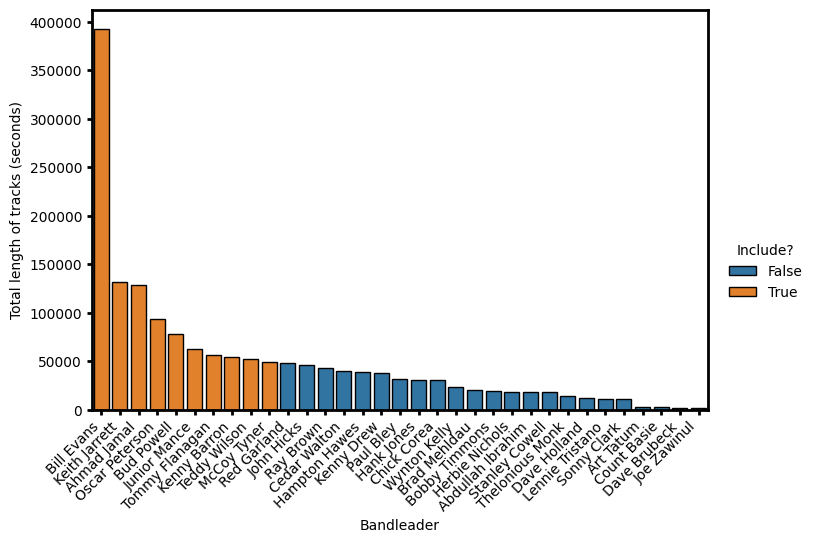

In [106]:
small = clean.groupby('bandleader').agg({'recording_title': 'count', 'recording_length_': 'sum'}).reset_index(drop=False)
small['recording_length_'] = small['recording_length_'].dt.total_seconds()
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
hand, lab_ = None, None
for var, lab in zip(['recording_length_'], ['Total length of tracks (seconds)',]):
    temp = small.sort_values(by=var, ascending=False).reset_index(drop=True)
    temp['color'] = temp.index < 10
    g = sns.barplot(temp, x='bandleader', y=var, ax=ax, estimator=np.sum, hue='color', dodge=False, edgecolor='black', lw=1)
    g.set_xticks(g.get_xticks(), g.get_xticklabels(), rotation=45, ha='right')
    g.set(ylabel=lab, xlabel='Bandleader')
    g.tick_params(width=2, which='both')
    plt.setp(g.spines.values(), linewidth=2)
    hand, lab_ = g.get_legend_handles_labels()
    g.get_legend().remove()
fig.legend(hand, lab_, loc='right', title='Include?', frameon=False)
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.87)
plt.show()

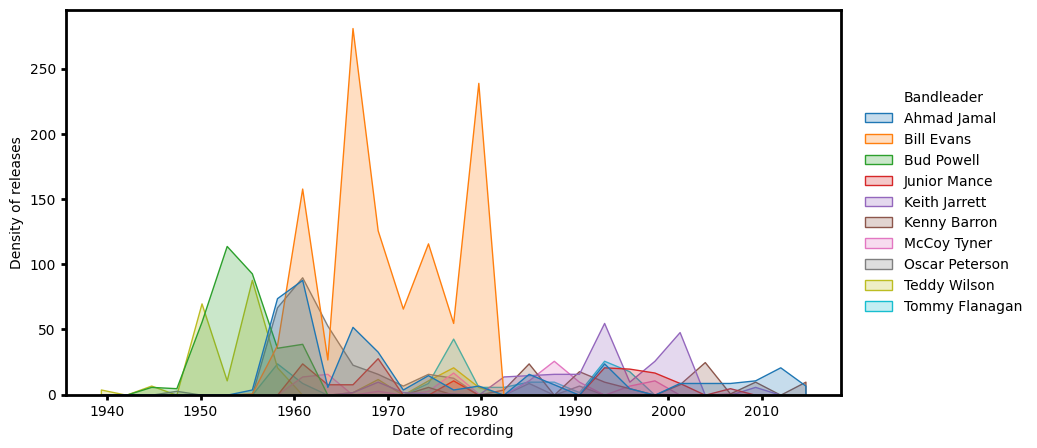

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
include = clean[clean['bandleader'].isin(leaders)]
include['year'] = include['recording_date_estimate'].dt.year
g = sns.histplot(data=include, x='year', hue='bandleader',  lw=1, element='poly')
g.set(xlabel='Date of recording', ylabel='Density of releases')
g.tick_params(width=2, which='both')
plt.setp(g.spines.values(), linewidth=2)
sns.move_legend(g, loc='right', title='Bandleader', bbox_to_anchor=(1.25, 0.5), frameon=False)
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(30, 20), sharex=False, sharey=False)
for a, (idx, grp) in zip(ax.flatten(), include.groupby('bandleader')):
    grp['track_length_'] = grp['track_length_'].dt.total_seconds()
    grp = grp.melt('track_length_', ['piano_', 'bass_', 'drums_']).reset_index(drop=True).groupby('value').agg({'track_length_': 'sum', 'variable': 'first'}).reset_index(drop=False).sort_values(by=['variable', 'track_length_'], ascending=False)
    g = sns.barplot(data=grp, x='value', y='track_length_', hue='variable', ax=a, dodge=False, hue_order=['piano_','bass_', 'drums_'], edgecolor='black', lw=1)
    g.set_xticks(g.get_xticks(), g.get_xticklabels(), rotation=45, ha='right')
    g.set(xlabel='', ylabel='', title=idx)
    hand, lab = g.get_legend_handles_labels()
    g.get_legend().remove()
fig.legend(hand, ['Piano', 'Bass', 'Drums'], loc='lower right', bbox_to_anchor=(0.75, 0.15), fontsize=20, title_fontsize=20, frameon=False, title='Instrument')
for a in ax.flatten()[-2:]:
    a.axis('off')
fig.supylabel('Time performed (seconds)')
fig.subplots_adjust(wspace=0.15, hspace=0.3, left=0.05)
plt.show()

In [94]:
include['date']

73      1994.505556
74      1985.586111
76      1958.127778
78      1967.516667
80      1958.766667
           ...     
6360    1960.466667
6361    1957.708333
6362    1957.708333
6363    1957.708333
6364    1960.466667
Name: date, Length: 3196, dtype: float64

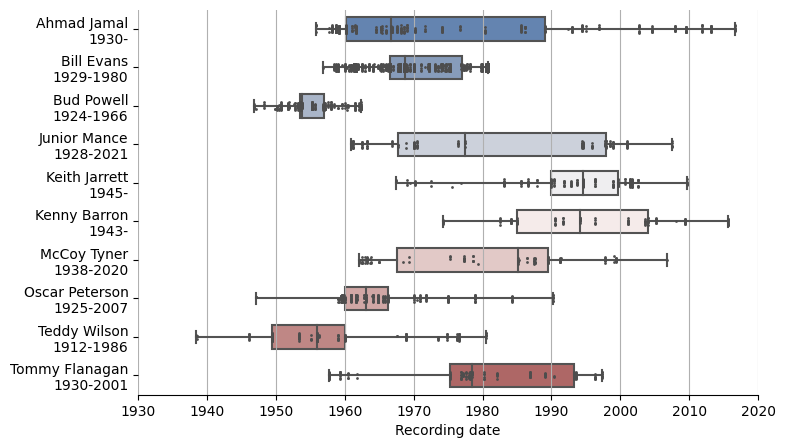

In [107]:
# sns.kdeplot(include, x='seconds', hue='bandleader', multiple='stack', common_norm=False, common_grid=True, log_scale=True)
include['seconds'] = include['recording_length_'].dt.total_seconds()
include['date'] = include['recording_date_estimate'].dt.year + ((include['recording_date_estimate'].dt.month + include['recording_date_estimate'].dt.day / 30)/ 12)
include['death_'] = include['death'].dt.year.astype(str).replace('2023', '')
include['bandleader_'] = include['bandleader'] + '\n' + include['birth'].dt.year.astype(str) + '-' + include['death_']
# include['year_'] = include['year'] + pd.to_timedelta(np.random.randint(1,1000000,len(include)))
f, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x="date", y="bandleader_", data=include,
            whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(x="date", y="bandleader_", data=include,
              size=2, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel="", xlabel='Recording date', xlim=(1930, 2020))
sns.despine(trim=True, left=True)

In [113]:
from pyvis.network import Network
import networkx as nx

g = include.drop_duplicates(subset=['bass_', 'drums_', 'bandleader']).melt('bandleader', ['bass_', 'drums_'])
got_net = Network(notebook=True, cdn_resources='remote', height='600px', width='100%')

sources = g['bandleader']
targets = g['value']
rewards = g['variable']


edge_data = zip(sources, targets, rewards)
for src, dst, reward in edge_data:
    got_net.add_node(src, title=src, color='green')
    if reward == 'bass_':
        got_net.add_node(dst, title=dst, color='red')
    if reward == 'drums_':
        got_net.add_node(dst, title=dst, color='blue')
    got_net.add_edge(src, dst)
    
got_net.show_buttons()
got_net.show('example.html', )

example.html
